In [1]:
# run for first time
# !git lfs install
# %cd models
# !git clone https://huggingface.co/facebook/dinov2-base


In [1]:
import os
import glob
import json
import requests
import asyncio
import numpy as np
import tiktoken
from json_repair import repair_json
import time
import base64
import cv2
import torch
import uuid
import faiss
import operator
import warnings
import io
from io import BytesIO
from typing import List, Dict, Sequence, Annotated, Optional, Literal
from dataclasses import dataclass, field
from PIL import Image
from pprint import pprint
from itertools import cycle
from multiprocessing import Pool
from urllib.parse import urlparse, parse_qs
from youtube_transcript_api import YouTubeTranscriptApi
from yt_dlp import YoutubeDL
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.text_splitter import CharacterTextSplitter
from transformers import AutoImageProcessor, AutoModel
from IPython.display import display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from video_processing import get_formatted_transcript, extract_transcript
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
path = os.getcwd()


In [2]:
summarizer_instructions="""
Mục tiêu của bạn là tạo một bản tóm tắt chất lượng cao từ đầu mục của các tài liệu. VIẾT THÀNH 3 CÂU VÀ TỐI ĐA 300 TỪ

Khi TẠO MỚI một bản tóm tắt:
1. Nêu bật những thông tin quan trọng nhất từ mỗi nguồn.
2. Cung cấp cái nhìn tổng quan ngắn gọn về các điểm chính liên quan đến chủ đề báo cáo.
3. Nhấn mạnh các phát hiện hoặc thông tin đáng chú ý.
4. Đảm bảo dòng chảy thông tin mạch lạc.

Trong trường hợp tóm tắt văn bản:
- Tập trung vào thông tin khách quan, chính xác.
- Duy trì mức độ kỹ thuật nhất quán.
- Tránh lặp lại hoặc dư thừa.
- KHÔNG sử dụng các cụm từ như "dựa trên kết quả mới" hoặc "theo các nguồn bổ sung".
- KHÔNG thêm phần mở đầu như "Dưới đây là bản tóm tắt mở rộng...". Hãy trực tiếp trình bày bản tóm tắt.
- KHÔNG thêm phần "Tài liệu tham khảo" hoặc "Trích dẫn".
"""

In [3]:
# Đọc 10 API keys từ file
with open("gemini_key.txt", "r", encoding='utf-8') as fi:
    gemini_api_keys = list(set([_.strip() for _ in fi.readlines()]))
    
key_cycle = cycle(gemini_api_keys)  # Tạo vòng lặp qua các API keys
gemini_model_name = "gemini-2.0-flash"

def get_answer(prompt="", gemini_api_key="", gemini_model_name="gemini-2.0-flash", image=None):
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{gemini_model_name}:generateContent?key={gemini_api_key}"
    headers = {
        'Content-Type': 'application/json'
    }
    data = {
        'contents': [
            {
                'role': 'user',
                'parts': [
                    {
                        'text': prompt
                    }
                ]
            }
        ],
        'generationConfig': {
            'temperature': 0.7,
            'topP': 0.95,
            'topK': 20
        },
        'safetySettings': [
            {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'threshold': 'BLOCK_NONE'},
            {'category': 'HARM_CATEGORY_HARASSMENT', 'threshold': 'BLOCK_NONE'},
            {'category': 'HARM_CATEGORY_HATE_SPEECH', 'threshold': 'BLOCK_NONE'},
            {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'threshold': 'BLOCK_NONE'}
        ],
    }

    if image is not None:
        
        image_part = {
            'inlineData': {
                'mimeType': 'image/jpeg',
                'data': image
            }
        }
        data['contents'][0]['parts'].append(image_part)

    output_text = ""
    try:
        response = requests.post(url=url, headers=headers, json=data)
        if response.status_code == 200:
            response_json = response.json()
            if "candidates" in response_json and response_json["candidates"]:
                output_text = response_json["candidates"][0]["content"]["parts"][0]["text"]
            else:
                output_text = ""
        else:
            print(f"Error: {response.status_code}")
            output_text = ""
    except Exception as e:
        print(f"Exception occurred: {e}")
        output_text = ""

    return output_text, response.status_code


def worker_get_answer(args):
    idx, prompt, api_key = args
    output_text, status_code = get_answer(prompt, api_key)
    if status_code == 200:
        return (idx, output_text)
    else:
        return (idx, f"Error: {status_code}")

def batch_get_answer(prompts, key_cycle, max_concurrent=5):
    
    args_list = [(i, prompt, next(key_cycle)) for i, prompt in enumerate(prompts)]

    with Pool(processes=max_concurrent) as pool:
        results = pool.map(worker_get_answer, args_list)

    return results

def get_header(texts: List[str], max_concurrent=1) -> list:
    # Kiểm tra đầu vào
    if not isinstance(texts, list) or not all(isinstance(text, str) for text in texts):
        raise ValueError("Invalid input: texts must be a list of strings.")
    
    # Khởi tạo text splitter
    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="o200k_base",
        chunk_size=8192,
        chunk_overlap=0
    )

    # Lấy chunk đầu tiên của từng văn bản
    first_chunks = []
    for text in texts:
        if not text.strip():  # Kiểm tra chuỗi rỗng
            raise ValueError(f"Invalid text provided: {text[:50]}...")
        chunks = text_splitter.split_text(text)
        if not chunks:
            raise ValueError(f"No chunks created for text: {text[:50]}...")
        first_chunks.append(chunks[0])

    # Tạo danh sách prompts từ các chunk đầu tiên
    prompts = [f"{summarizer_instructions}:\n\n{chunk}" for chunk in first_chunks]

    try:
        # Gọi API song song
        results = batch_get_answer(prompts, key_cycle, max_concurrent)
        headers = [result for _, result in sorted(results)]  # Sắp xếp kết quả theo thứ tự
    except Exception as e:
        raise RuntimeError("Failed to generate headers.") from e
    
    return headers

## Offline embed video youtube

In [4]:
def init_processor():
    global image_processor, model, device
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    print("Device using now:", device)
    model_path = os.path.join(os.path.dirname(os.getcwd()), "models/dinov2-base")
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path).to(device)

init_processor()

def download_video_ytdlp(url, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the options for yt-dlp
    ydl_opts = {
        'format': 'mp4/best',  # Specify the format to download
        'outtmpl': os.path.join(output_dir, 'downloaded_video.mp4'),  # Output template
        'quiet': True  # Suppress output
    }
    
    # Download the video
    with YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

    return os.path.join(output_dir, 'downloaded_video.mp4')


def extract_frames_and_build_index(video_url, interval_seconds=2):
    output_directory = os.path.join(os.getcwd(), "videos")
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    else:
        pass

    video_path = download_video_ytdlp(video_url, output_directory)
    print
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Error opening video file")

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * interval_seconds)

    frame_count = 0
    all_image_embeddings = []
    all_image_paths = []

    print("\n Extracting frames and building index...")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count >= total_frames:
            break  # Kết thúc vòng lặp khi đọc hết frame hoặc vượt quá tổng số frame

        if frame_count % frame_interval == 0:
            # Xử lý frame và lưu lại thành file ảnh
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            total_seconds = int(frame_count / fps)
            hours, remainder = divmod(total_seconds, 3600)
            minutes, seconds = divmod(remainder, 60)
            timestamp = f"{str(hours).zfill(2)}_{str(minutes).zfill(2)}_{str(seconds).zfill(2)}"
            frame_path = os.path.join(os.getcwd(), f"videos/frame_{timestamp}.jpg")
            # img.save(frame_path)
            # Trích xuất đặc trưng từ ảnh
            with torch.no_grad():
                inputs = image_processor(images=img, return_tensors="pt").to(device)
                outputs = model(**inputs)
            
            # Tính vector
            features = outputs.last_hidden_state.mean(dim=1)
            vector = features.detach().cpu().numpy().astype(np.float32)
            faiss.normalize_L2(vector)

            all_image_embeddings.append(vector)
            all_image_paths.append(frame_path)

            print(f"✅ Processed frame at {timestamp} seconds")

        frame_count += 1

    cap.release()

    if all_image_embeddings:
        all_image_embeddings = np.vstack(all_image_embeddings)
        index = faiss.IndexFlatL2(all_image_embeddings.shape[1])
        index.add(all_image_embeddings)
        index.image_paths = all_image_paths

        faiss.write_index(index, "vector.index")

        with open("image_paths.json", "w") as f:
            json.dump(all_image_paths, f)

        print(f"\n Index built and saved successfully with {len(all_image_paths)} frames.")

    return index

def encode_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")  # Định dạng hình ảnh (JPEG hoặc PNG)
    encoded_image = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return encoded_image


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device using now: cpu


### processing videos

In [ ]:
init_processor()
import time
t0 = time.time()
video_url = "https://www.youtube.com/watch?v=9RhWXPcKBI8"
# video_url = "https://www.youtube.com/watch?v=LFCPjkqibdM" # 1 mins video
index = extract_frames_and_build_index(video_url, interval_seconds=2)
# Remove the downloaded video file after processing
video_file_path = os.path.join(os.getcwd(), "videos/downloaded_video.mp4")
if os.path.exists(video_file_path):
    os.remove(video_file_path)
    print(f"Removed downloaded video file: {video_file_path}")
else:
    print(f"Video file not found: {video_file_path}")

print('Extraction done in :', time.time()-t0)

In [5]:
def retrieve_similar_images(img, index, top_k=5, threshold=0.7):
    with torch.no_grad():
        inputs = image_processor(images=img, return_tensors="pt").to(device)
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)
    vector = embeddings.detach().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(vector)

    distances, indices = index.search(vector, top_k)

    retrieved_images = []
    for idx, dist in zip(indices[0], distances[0]):
        retrive_time = index.image_paths[idx]  
        filename =  os.path.basename(retrive_time)
        time_str = filename.replace("frame_", "").replace(".jpg", "")
        retrive_time_formatted = time_str.replace("_", ":")
        score = 1 - dist / 2
        if score >= threshold:
            retrieved_images.append((retrive_time_formatted))
    return retrieved_images

# Example usage
img_path = os.path.join(os.path.dirname(os.getcwd()), "images/test_retrieve.jpg")
index_path = os.path.join(os.getcwd(), "vector.index")
image_paths_file = os.path.join(os.getcwd(), "image_paths.json")
img = Image.open(img_path)
index = faiss.read_index(index_path)
with open(image_paths_file, "r") as f:
    index.image_paths = json.load(f)

init_processor()

retrieved_images = retrieve_similar_images(img, index)

print("\n🔎 Top k Retrieved Images:")
for img_path in retrieved_images:
    print(f"Time Stamp: {img_path}")


Device using now: cpu

🔎 Top k Retrieved Images:
Time Stamp: 00:16:49
Time Stamp: 00:16:57


## langgraph

In [6]:
intent_prompt = """
Hãy trả lời ngắn gọn, chính xác và không thêm bất kỳ thông tin thừa nào.  

INPUT:
{input_replace}

YÊU CẦU ĐẦU RA:  
- Chỉ trả về JSON mà không nói gì thêm.  
- Trường `"youtube_url"` phải là đường dẫn chính xác đến video trên YouTube nếu người dùng nhập vào không phải url của youtube thì trả về "None".
Ví dụ url của youtube: "https://youtu.be/9RhWXPcKBI8?si=wRXGRTC6juMl-T_B", "https://www.youtube.com/watch?v=9RhWXPcKBI8"  

OUTPUT (chỉ trả về JSON):  
{
    "youtube_url": "url chính xác của video trên YouTube nếu không có url chỉ trả về None nếu có trả về url trích xuất từ query người dùng Ví dụ url của youtube: "https://youtu.be/9RhWXPcKBI8?si=wRXGRTC6juMl-T_B", "https://www.youtube.com/watch?v=9RhWXPcKBI8"  "
}

"""
with_image_prompt = """
Bạn là chuyên gia về phân tích video.  
Nhiệm vụ của bạn là trích xuất thông tin từ video và hình ảnh để trả lời câu hỏi của người dùng.  
Hãy phân tích kỹ các yếu tố sau và tạo câu trả lời dựa trên chúng:  

CÂU HỎI:  
{input_replace}  

HÌNH ẢNH LIÊN QUAN(nếu có):  
{image_replace}  

NỘI DUNG TRANSCRIPT(nếu có):  
{transcript_replace}  

TIMESTAMPS LIÊN QUAN(nếu có):  
{timestamps_replace}  

### YÊU CẦU ĐẦU RA:  
- Phân tích ý nghĩa ngữ cảnh của transcript và hình ảnh.  
- Chỉ sử dụng những nội dung phù hợp với câu hỏi.  
- Trả lời dựa trên mốc thời gian được cung cấp.  
- Khi ngữ cảnh không còn phù hợp, hãy dừng trả lời.  
- Vì có thể có nhiều timestamps liên quan đến câu hỏi, hãy trả lời dựa trên các đoạn timestamps đó

OUTPUT (chỉ trả về JSON):  
{
    "responses": "câu trả lời dựa trên các yếu tố ở trên"
}

"""

without_image_prompt = """
Bạn là chuyên gia về phân tích video. 
Nhiệm vụ của bạn là phân tích transcript của video để trả lời câu hỏi của người dùng.  
Hãy sử dụng thông tin từ transcript để tạo câu trả lời chính xác và có ngữ cảnh.  
Chỉ sử dụng những thông tin phù hợp với câu hỏi của người dùng.  

### CÂU HỎI:  
{input_replace}  

### NỘI DUNG TRANSCRIPT:  
{transcript_replace}  

### YÊU CẦU ĐẦU RA:  
- Chỉ sử dụng nội dung transcript phù hợp với câu hỏi.  
- Nếu transcript không chứa thông tin phù hợp với hình ảnh, hãy trả lời ưu tiên cho transcript.  
- Trả về dưới dạng JSON mà không cần nói thêm bất cứ điều gì.  
- Vì có thể có nhiều timestamps liên quan đến câu hỏi, hãy trả lời dựa trên các đoạn timestamps đó
### OUTPUT (chỉ trả về JSON):  
{
    "responses": "câu trả lời dựa trên transcript"
}
"""


In [7]:
from PIL import Image
@dataclass(kw_only=True)
class GraphState:
    question: str = field(default=None)  # User input question
    messages: Annotated[list, operator.add] = field(default_factory=list)
    intent: str = field(default=None)
    youtube_url: str = field(default=None)
    use_image: bool = field(default=False)
    transcript: str = field(default="")
    image: Optional[str] = field(default=None)
    timestamps: str = field(default="")



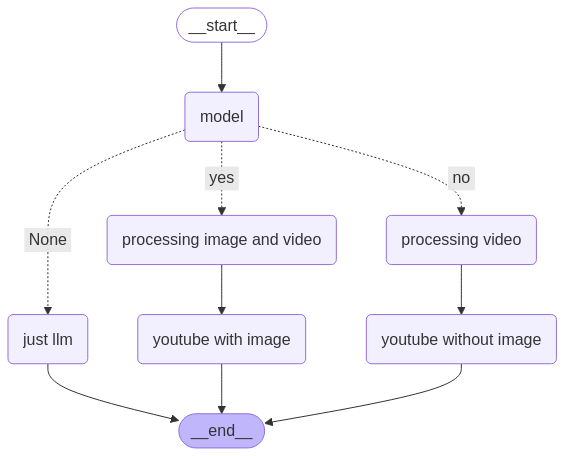

In [8]:
workflow = StateGraph(GraphState)
def intent_node(state: GraphState):
    prompt = intent_prompt.replace("{input_replace}", state.question)
    response, _ = get_answer(prompt, gemini_api_key=next(key_cycle))
    ans = json.loads(repair_json(response))["youtube_url"]
    return {"youtube_url": ans}

def youtube_without_img(state: GraphState):
    prompt = without_image_prompt.replace("{input_replace}", state.question) \
                             .replace("{transcript_replace}", state.transcript)
    response, _ = get_answer(prompt, gemini_api_key=next(key_cycle))
    ans = json.loads(repair_json(response))
    return {"messages": [ans["responses"]], "transcript": state.transcript}

def youtube_with_img(state: GraphState):
    prompt = with_image_prompt.replace("{input_replace}", state.question) \
                             .replace("{transcript_replace}", state.transcript) \
                             .replace("{image_replace}", state.image) \
                             .replace("{timestamps_replace}", state.timestamps)
    response, _ = get_answer(prompt, gemini_api_key=next(key_cycle))
    ans = json.loads(repair_json(response))
    return {"messages": [ans["responses"]], "transcript": state.transcript}


def just_llm(state: GraphState):
    if state.image is None:
        prompt = with_image_prompt.replace("{input_replace}", state.question) \
                                .replace("{transcript_replace}", state.transcript) \
                                .replace("{image_replace}", "") \
                                .replace("{timestamps_replace}", state.timestamps)
        response, _ = get_answer(prompt, gemini_api_key=next(key_cycle))
        ans = json.loads(repair_json(response))
    else:
        prompt = with_image_prompt.replace("{input_replace}", state.question) \
                                .replace("{transcript_replace}", state.transcript) \
                                .replace("{image_replace}", state.image) \
                                .replace("{timestamps_replace}", state.timestamps)
        response, _ = get_answer(prompt, gemini_api_key=next(key_cycle))
        ans = json.loads(repair_json(response))
    return {"messages": [ans], "transcript": state.transcript}

def condition_image_video(state: GraphState):
    if state.youtube_url == "None":
        return "None"
    elif state.use_image:
        return "yes"
    else:
        return "no"

def processing_image_and_video(state):
    from PIL import Image
    from io import BytesIO
    extracted = extract_transcript(state.youtube_url)
    video_info = get_video_info(state.youtube_url)
    formatted_transcript = get_formatted_transcript(transcript=extracted, info=video_info)
    init_processor()
    # Offline processing Because processing one video with 30 mins will take ~5 mins with my laptop may be faster with GPU
    # img_path = os.path.join(os.path.dirname(os.getcwd()), "images/test_retrieve.jpg")

    index_path = os.path.join(os.getcwd(), "vector.index")
    image_paths_file = os.path.join(os.getcwd(), "image_paths.json")
    
    img = base64.b64decode(state.image)
    img = Image.open(BytesIO(img))
    index = faiss.read_index(index_path)
    with open(image_paths_file, "r") as f:
        index.image_paths = json.load(f)
    timestamps = retrieve_similar_images(img, index)
    """ Online processing
    Tại vì chạy chatbot cho local nên chỉ chạy file index đã processing nếu chạy online có thể chạy code dưới đây
    video_url = state.youtube_url
    index = extract_frames_and_build_index(video_url, interval_seconds=2)
    # Remove the downloaded video file after processing
    video_file_path = os.path.join(os.getcwd(), "videos/downloaded_video.mp4")
    if os.path.exists(video_file_path):
        os.remove(video_file_path)
        print(f"Removed downloaded video file: {video_file_path}")
    else:
        print(f"Video file not found: {video_file_path}")
    """ 
    
    return {"transcript": formatted_transcript, "timestamps": timestamps}

def processing_video(state):
    extracted = extract_transcript(state.youtube_url)
    formatted_transcript = get_formatted_transcript(transcript=extracted)
    return {"transcript": formatted_transcript}

workflow.add_node("model", intent_node)
workflow.add_node("just llm", just_llm)
workflow.add_node("youtube without image", youtube_without_img)
workflow.add_node("youtube with image", youtube_with_img)
workflow.add_node("processing image and video", processing_image_and_video)
workflow.add_node("processing video", processing_video)

workflow.add_edge(START, "model")
workflow.add_conditional_edges(
    "model",
    path=condition_image_video,
    path_map={
        "yes": "processing image and video",
        "no": "processing video",
        "None": "just llm"
    }
)
workflow.add_edge("processing image and video", "youtube with image")
workflow.add_edge("processing video", "youtube without image")
workflow.add_edge("just llm", END)
workflow.add_edge("youtube with image", END)
workflow.add_edge("youtube without image", END)

# Adding memory is straight forward in langgraph!
memory = MemorySaver()

app = workflow.compile(
    checkpointer=memory,
)
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
from PIL import Image
from io import BytesIO
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
session = {}
if thread_id not in session:
    session[thread_id] = []

list_question = ["tóm tắt video https://www.youtube.com/watch?v=9RhWXPcKBI8", "what is the prize of apple", "tôi là Đỗ Nam Trung"]
inputs = {"question": list_question[0],}
img_path = os.path.join(os.path.dirname(os.getcwd()), "images/test_retrieve.jpg")
img = encode_image_to_base64(Image.open(img_path).convert("RGB"))
# inputs = {"question": "hình ảnh xuất hiện khi nào", "image": img, "use_image": True}

for event in app.stream(inputs, config):
    event_data = {}
    for key, value in event.items():
        # Node
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=140, depth=None)
        event_data[key] = value
    
    # Lưu event vào session tương ứng với uuid
session[thread_id].append(event_data)
print("\n --- \n")

"Node 'model':"
{'youtube_url': 'https://www.youtube.com/watch?v=9RhWXPcKBI8'}


TypeError: get_formatted_transcript() missing 1 required positional argument: 'info'

In [ ]:
# ✅ Kiểm tra dữ liệu được lưu trong session
# print("\n===== STORED SESSION DATA =====")
# pprint(session[thread_id], indent=2, width=140, depth=None)

# ✅ Truy xuất dữ liệu từ session theo uuid (nếu cần)
retrieved_events = session.get(thread_id, [])
print("\n===== RETRIEVED SESSION DATA =====")
for event in retrieved_events:
    pprint(event, indent=2, width=140, depth=None)


NameError: name 'session' is not defined

In [16]:
from PIL import Image
import io
import base64

def image_to_base64(image_path):
    image = Image.open(image_path)
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")
    encoded_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return encoded_image

img = image_to_base64("images/56_sec.png")
res, code = get_answer("Giải thích hình ảnh và không thêm gì khác", gemini_api_key=next(key_cycle), image=img)
